In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

%matplotlib inline

In [2]:
cifar100 = tf.keras.datasets.cifar100
(X_train,Y_train) , (X_test,Y_test) = cifar100.load_data()

In [3]:
classes = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]


In [4]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train,test_size=0.2)

In [5]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)

In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg19.preprocess_input,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True
)
train_datagen.fit(x_train)

val_datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg19.preprocess_input)
val_datagen.fit(x_val)

In [7]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [8]:
vgg_model = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

for layer in vgg_model.layers:
    layer.trainable = False

vgg_model.summary()

vgg_model.trainable = False

2024-11-20 04:29:24.508717: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Ultra
2024-11-20 04:29:24.508750: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2024-11-20 04:29:24.508756: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2024-11-20 04:29:24.508770: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-20 04:29:24.508783: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [9]:
for layers in vgg_model.layers:
    layers.trainable = False

In [10]:
# Define your model
model = tf.keras.Sequential()# Resize layer
model.add(tf.keras.layers.Resizing(224, 224, interpolation="bilinear"))
model.add(vgg_model)  # Add vgg19
model.add(Flatten())  # Flatten the output and add dense layers
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(512, activation='tanh'))
model.add(Dense(100, activation='softmax'))  # Final layer for 100 classes

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [11]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer= optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [12]:
history = model.fit(
    train_datagen.flow(x_train, y_train),
    validation_data = val_datagen.flow(x_val,y_val),
    epochs = 100,
    verbose = 1,
    # callbacks = [learning_rate_reduction]
)

Epoch 1/100


/Users/thomasjones/.pyenv/versions/3.10.15/envs/unet/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-11-20 04:29:25.425729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 160s 126ms/step - accuracy: 0.3998 - loss: 2.4269 - val_accuracy: 0.5930 - val_loss: 1.4491
Epoch 2/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 158s 126ms/step - accuracy: 0.5700 - loss: 1.5222 - val_accuracy: 0.6107 - val_loss: 1.3841
Epoch 3/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 158s 126ms/step - accuracy: 0.5983 - loss: 1.4060 - val_accuracy: 0.6208 - val_loss: 1.3705
Epoch 4/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 158s 126ms/step - accuracy: 0.6115 - loss: 1.3510 - val_accuracy: 0.6195 - val_loss: 1.3582
Epoch 5/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 158s 126ms/step - accuracy: 0.6220 - loss: 1.3105 - val_accuracy: 0.6242 - val_loss: 1.3535
Epoch 6/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 158s 126ms/step - accuracy: 0.6296 - loss: 1.2837 - val_accuracy: 0.6226 - val_loss: 1.3621
Epoch 7/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 158s 126ms/step - accuracy: 0.6362 - loss: 1.2682 - val_accuracy: 0.6222 - val_loss: 1.3678
Epoch 8/100
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 158s 126ms/step - accura

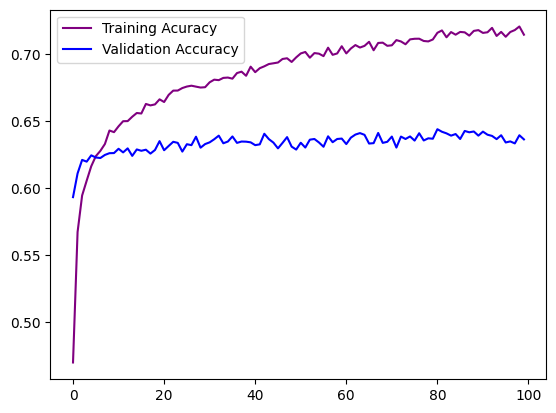

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure()
plt.plot(acc,color = 'purple',label = 'Training Acuracy')
plt.plot(val_acc,color = 'blue',label = 'Validation Accuracy')
plt.legend()

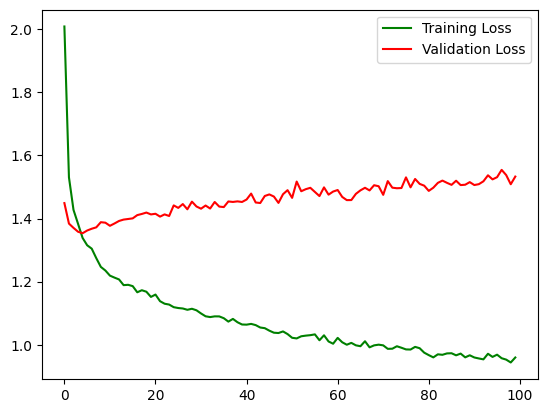

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

model.save('./100vggepoch512dense.keras')

plt.figure()
plt.plot(loss,color = 'green',label = 'Training Loss')
plt.plot(val_loss,color = 'red',label = 'Validation Loss')
plt.legend()

In [15]:
# Preprocess the input
x_test = tf.keras.applications.resnet50.preprocess_input(X_test)

# Get predictions
y_pred_prob = model.predict(x_test)  # Get the probability predictions
y_pred = y_pred_prob.argmax(axis=-1)  # Get the class predictions

# Display the first 10 predictions
y_pred[:10]


313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 94ms/step


array([49, 33, 32, 55, 71,  6, 34,  7, 71, 57])

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score
print('Testing Accuarcy : ', accuracy_score(Y_test, y_pred))

Testing Accuarcy :  0.6415


Overall AUC-ROC score: 0.9869504444444444
Mean Average Precision (MAP): 0.7007287215771466
Precision (mean across classes): 0.7007287215771466


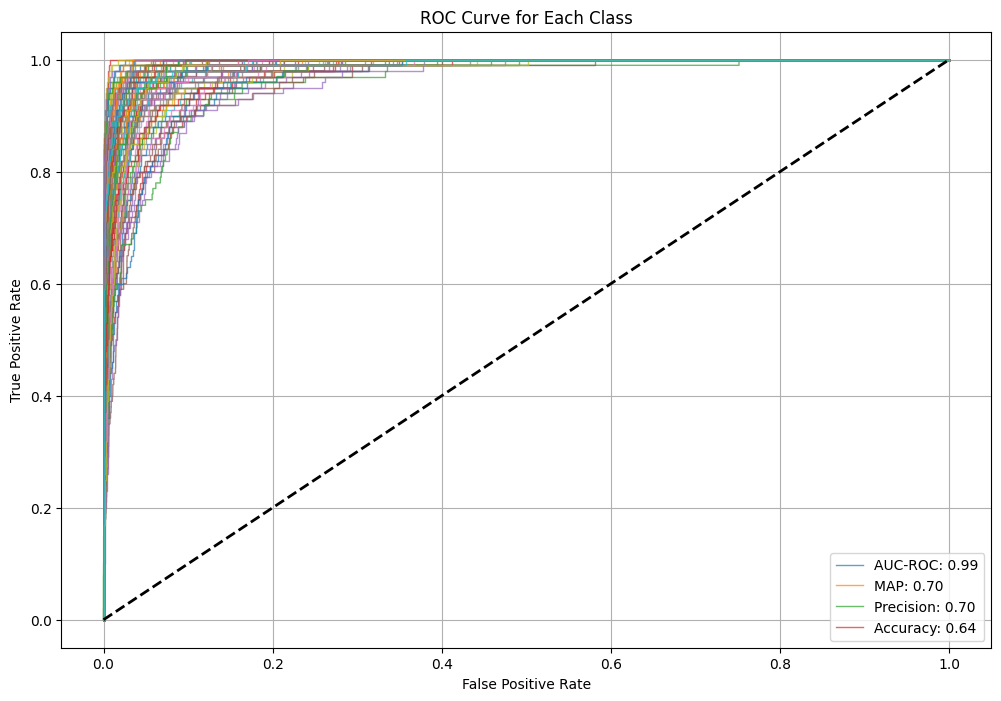

In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class AUC computation
n_classes = y_pred_prob.shape[1]  # Automatically set to the number of output classes
Y_test_binarized = label_binarize(Y_test, classes=np.arange(n_classes))

# Compute the overall AUC-ROC score using one-vs-rest (OvR)
auc_roc = roc_auc_score(Y_test_binarized, y_pred_prob, multi_class='ovr')
print("Overall AUC-ROC score:", auc_roc)

# Compute Mean Average Precision (MAP)
map_score = average_precision_score(Y_test_binarized, y_pred_prob, average='macro')
print("Mean Average Precision (MAP):", map_score)

# Compute Precision score for each class (one-vs-rest) and average
precision_per_class = average_precision_score(Y_test_binarized, y_pred_prob, average=None)
precision = np.mean(precision_per_class)
print("Precision (mean across classes):", precision)

# Plot the ROC curve for each class without adding class labels on the plot
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(Y_test_binarized[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, lw=1, alpha=0.7)  # Reduced opacity for clarity

# Additional details for the plot
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal reference line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')

# Add custom legend with metrics
plt.legend([f"AUC-ROC: {auc_roc:.2f}",
            f"MAP: {map_score:.2f}",
            f"Precision: {precision:.2f}",
            f"Accuracy: {accuracy_score(Y_test, y_pred):.2f}"],
           loc='lower right')

plt.grid(True)  # Add grid lines for better readability
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 94ms/step


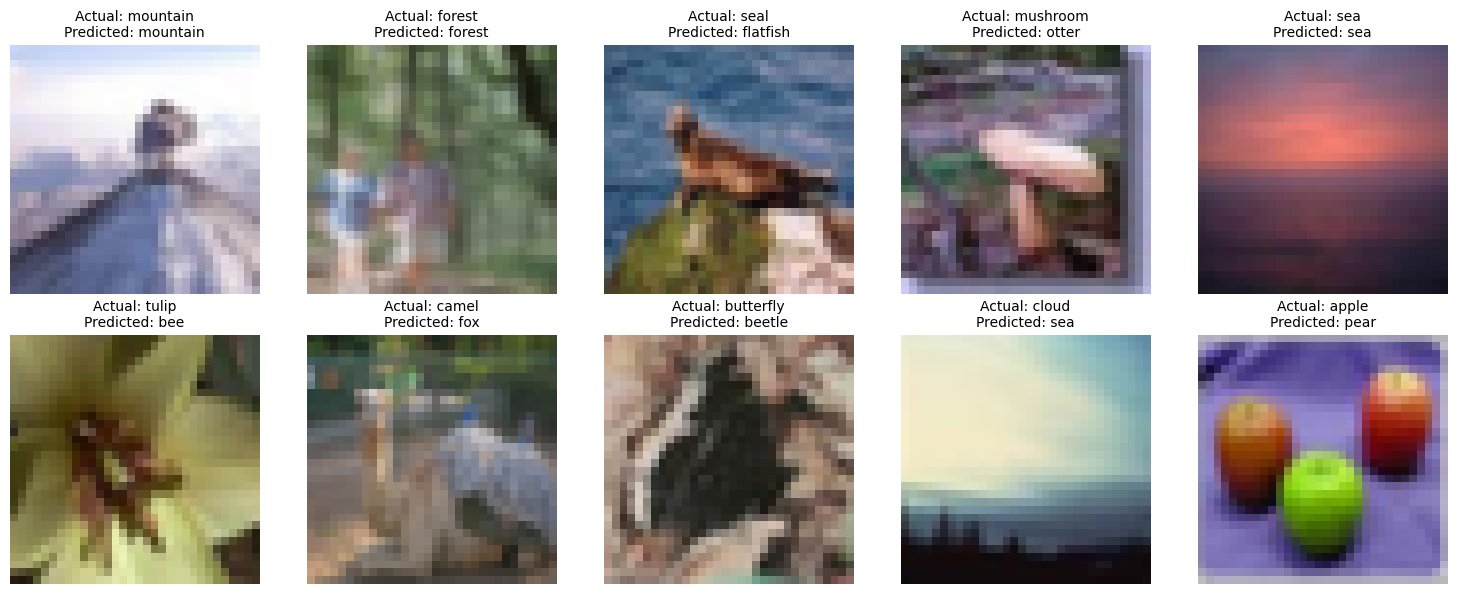

In [20]:

# Ensure the model has been used to make predictions on x_test
y_pred_prob = model.predict(x_test)
y_pred = y_pred_prob.argmax(axis=-1)  # Get the class predictions

# Define the number of images to display
num_images = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Display in a 2x5 grid

for i, ax in enumerate(axes.flat):
    # Display the image
    ax.imshow(X_test[i].astype("uint8"))  # Ensure the image is uint8 for correct display
    
    # Set the title with actual and predicted labels
    actual_label = classes[Y_test[i][0]]
    predicted_label = classes[y_pred[i]]
    ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)
    
    # Remove the axes for a cleaner look
    ax.axis('off')

plt.tight_layout()
plt.show()
